# A1: Data Curation Assignment

**To measure Wikipedia traffic from 2008-2021**

In [249]:
import json
import requests
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from pprint import pprint

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

In [250]:
# Defining endpoints and paths

endpoint_legacy = 'https://wikimedia.org/api/rest_v1/metrics/legacy/pagecounts/aggregate/{project}/{access-site}/{granularity}/{start}/{end}'
endpoint_pageviews = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/{project}/{access}/{agent}/{granularity}/{start}/{end}'

pagecounts_desktop_outfile_path = "./raw/pagecounts_desktop-site_200712-201608.json"
pagecounts_mobile_outfile_path  = "./raw/pagecounts_mobile-site_200712-201608.json"

pageviews_desktop_outfile_path   = "./raw/pageviews_desktop_201507-202112.json"
pageviews_mobile_web_outfile_path = "./raw/pageviews_mobile-web_201507-202112.json"
pageviews_mobile_app_outfile_path = "./raw/pageviews_mobile-app_201507-202112.json"

# The output files.
csv_outfile_path = "./en-wikipedia_traffic_200712-202112.csv"
png_outfile_path = "./en-wikipedia_traffic_200712-202112.png"

In [251]:
#function for API endpoint call
def api_call(endpoint,parameters):
    call = requests.get(endpoint.format(**parameters), headers=headers)
    response = call.json()
    return response

## Step 1: Data acquisition

*Building API calls for data collection.*

In [252]:
#headers
headers = {
    'User-Agent': 'https://github.com/smuktevi',
    'From': 'vmuktev1@uw.edu'
}

*Example*

In [253]:
# SAMPLE parameters for getting aggregated legacy view data 
# see: https://wikimedia.org/api/rest_v1/#!/Legacy_data/get_metrics_legacy_pagecounts_aggregate_project_access_site_granularity_start_end
example_params_legacy = {"project" : "en.wikipedia.org",
                 "access-site" : "desktop-site",
                 "granularity" : "monthly",
                 "start" : "2001010100",
                # for end use 1st day of month following final month of data
                 "end" : "2018100100"
                    }

# SAMPLE parameters for getting aggregated current standard pageview data
# see: https://wikimedia.org/api/rest_v1/#!/Pageviews_data/get_metrics_pageviews_aggregate_project_access_agent_granularity_start_end
example_params_pageviews = {"project" : "en.wikipedia.org",
                    "access" : "desktop",
                    "agent" : "user",
                    "granularity" : "monthly",
                    "start" : "2001010100",
                    # for end use 1st day of month following final month of data
                    "end" : '2018101000'
                        }

example_monthly_pageviews = api_call(endpoint_pageviews, example_params_pageviews)
pprint(example_monthly_pageviews)

example_monthly_legacy = api_call(endpoint_legacy, example_params_legacy)
pprint(example_monthly_legacy)

{'items': [{'access': 'desktop',
            'agent': 'user',
            'granularity': 'monthly',
            'project': 'en.wikipedia',
            'timestamp': '2015070100',
            'views': 4376666686},
           {'access': 'desktop',
            'agent': 'user',
            'granularity': 'monthly',
            'project': 'en.wikipedia',
            'timestamp': '2015080100',
            'views': 4332482183},
           {'access': 'desktop',
            'agent': 'user',
            'granularity': 'monthly',
            'project': 'en.wikipedia',
            'timestamp': '2015090100',
            'views': 4485491704},
           {'access': 'desktop',
            'agent': 'user',
            'granularity': 'monthly',
            'project': 'en.wikipedia',
            'timestamp': '2015100100',
            'views': 4477532755},
           {'access': 'desktop',
            'agent': 'user',
            'granularity': 'monthly',
            'project': 'en.wikipedia',
            '

*Parameters for required API calls.*

In [254]:
params_legacy = {"project" : "en.wikipedia.org",
                 "access-site" : None,
                 "granularity" : "monthly",
                 "start" : "2007120100",
                 "end" : "2016080100"
                }
params_pageviews = {"project" : "en.wikipedia.org",
                    "access" : None,
                    "agent" : "user",
                    "granularity" : "monthly",
                    "start" : "2015070100",
                    "end" : "2022010100"
                   }

*Get JSON data using API Endpoints and parameters.*

In [255]:
#from legacy
for access_site in ["desktop-site", "mobile-site"]:
    params_legacy["access-site"] = access_site
    json_data = api_call(endpoint_legacy, params_legacy)
    outfile_path = "./raw/pagecounts_{}_{}-{}.json".format(access_site, "20071201","20160801")
    with open(outfile_path, "w") as f:
        json.dump(json_data, f)
        
#from pageviews
for access in ["desktop", "mobile-app", "mobile-web"]:
    params_pageviews["access"] = access
    json_data = api_call(endpoint_pageviews, params_pageviews)
    outfile_path = "./raw/pageviews_{}_{}-{}.json".format(access, "20150701","20220101")
    with open(outfile_path, "w") as f:
        json.dump(json_data, f)

## Step 2: Data Processing

In [256]:
def json_data_process(filename, json_data):
    data = pd.json_normalize(json_data, record_path="items")
    data["year"] = data.timestamp.apply(lambda s: s[:4])
    data["month"] = data.timestamp.apply(lambda s: s[4:6])
    return data

directory = './raw/'
data = pd.DataFrame(columns = ['project', 'access-site', 'granularity', 'timestamp', 'count', 'year', 'month', "access", "agent", "views"])
for filename in os.listdir(directory):
    if filename.endswith(".json"):
        with open(directory+filename) as f:
            json_data = json.load(f)
            data = data.append(json_data_process(filename, json_data))
    else:
        continue
data

,project,access-site,granularity,timestamp,count,year,month,access,agent,views
0,en.wikipedia,mobile-site,monthly,2014100100,3091546685,2014,10,NaN,NaN,NaN
1,en.wikipedia,mobile-site,monthly,2014110100,3027489668,2014,11,NaN,NaN,NaN
2,en.wikipedia,mobile-site,monthly,2014120100,3278950021,2014,12,NaN,NaN,NaN
3,en.wikipedia,mobile-site,monthly,2015010100,3485302091,2015,01,NaN,NaN,NaN
4,en.wikipedia,mobile-site,monthly,2015020100,3091534479,2015,02,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
99,en.wikipedia,desktop-site,monthly,2016030100,5407676056,2016,03,NaN,NaN,NaN
100,en.wikipedia,desktop-site,monthly,2016040100,5572235399,2016,04,NaN,NaN,NaN
101,en.wikipedia,desktop-site,monthly,2016050100,5330532334,2016,05,NaN,NaN,NaN
102,en.wikipedia,desktop-site,monthly,2016060100,4975092447,2016,06,NaN,NaN,NaN


In [257]:
data['count'] = data['count'].combine_first(data['views'])
df = data.drop(columns=["project", "granularity", "timestamp", "agent", "views"])
new_df = df.copy()
new_df

,access-site,count,year,month,access
0,mobile-site,3091546685,2014,10,NaN
1,mobile-site,3027489668,2014,11,NaN
2,mobile-site,3278950021,2014,12,NaN
3,mobile-site,3485302091,2015,01,NaN
4,mobile-site,3091534479,2015,02,NaN
...,...,...,...,...,...
99,desktop-site,5407676056,2016,03,NaN
100,desktop-site,5572235399,2016,04,NaN
101,desktop-site,5330532334,2016,05,NaN
102,desktop-site,4975092447,2016,06,NaN


In [258]:
new_df.access[new_df["access"]=="mobile-web"] = "mobile-app"
new_df.access[new_df["access"]=="mobile-app"] = "pageview_mobile_views"
new_df.access[new_df["access"]=="desktop"] = "pageview_desktop_views"

new_df["access-site"][new_df["access-site"]=="mobile-site"] = "pagecount_mobile_views"
new_df["access-site"][new_df["access-site"]=="desktop-site"] = "pagecount_desktop_views"
new_df['access-site'] = new_df['access-site'].combine_first(new_df['access'])

print(new_df["access-site"].value_counts())

pageview_mobile_views      150
pagecount_desktop_views    104
pageview_desktop_views      75
pagecount_mobile_views      22
Name: access-site, dtype: int64


In [259]:
final_df = new_df.drop(columns="access").groupby(by=["access-site","year", "month"], dropna=False).sum().reset_index()
final_df

,access-site,year,month,count
0,pagecount_desktop_views,2007,12,2998331524
1,pagecount_desktop_views,2008,01,4930902570
2,pagecount_desktop_views,2008,02,4818393763
3,pagecount_desktop_views,2008,03,4955405809
4,pagecount_desktop_views,2008,04,5159162183
...,...,...,...,...
271,pageview_mobile_views,2021,05,4976579558
272,pageview_mobile_views,2021,06,4584510417
273,pageview_mobile_views,2021,07,4778909421
274,pageview_mobile_views,2021,08,4732194000


In [260]:
pivot_df = final_df.pivot(columns='access-site', index = ['year', 'month'], values = "count").reset_index()
pivot_df

access-site,year,month,pagecount_desktop_views,pagecount_mobile_views,pageview_desktop_views,pageview_mobile_views
0,2007,12,2.998332e+09,NaN,NaN,NaN
1,2008,01,4.930903e+09,NaN,NaN,NaN
2,2008,02,4.818394e+09,NaN,NaN,NaN
3,2008,03,4.955406e+09,NaN,NaN,NaN
4,2008,04,5.159162e+09,NaN,NaN,NaN
...,...,...,...,...,...,...
161,2021,05,NaN,NaN,2.824416e+09,4.976580e+09
162,2021,06,NaN,NaN,2.505971e+09,4.584510e+09
163,2021,07,NaN,NaN,2.765584e+09,4.778909e+09
164,2021,08,NaN,NaN,2.763414e+09,4.732194e+09


In [261]:
date_range_list = pd.date_range('2008-01-01','2021-12-01', freq='MS').strftime("%Y-%m").tolist()
time_df = pd.DataFrame({'time':date_range_list})
time_df['year'] = time_df['time'].apply(lambda s: s[:4])
time_df['month'] = time_df['time'].apply(lambda s: s[-2:])
time_df.drop(columns=['time'], inplace=True)
time_df

,year,month
0,2008,01
1,2008,02
2,2008,03
3,2008,04
4,2008,05
...,...,...
163,2021,08
164,2021,09
165,2021,10
166,2021,11


In [262]:
merge_df = pd.merge(pivot_df, time_df, on=['year', 'month'], how="outer")
merge_df.fillna(0, inplace=True)
merge_df["pagecount_all_views"] = merge_df["pagecount_desktop_views"] + merge_df["pagecount_mobile_views"]
merge_df["pageview_all_views"] = merge_df["pageview_desktop_views"] + merge_df["pageview_mobile_views"]
result_df = merge_df.copy()
result_df

,year,month,pagecount_desktop_views,pagecount_mobile_views,pageview_desktop_views,pageview_mobile_views,pagecount_all_views,pageview_all_views
0,2007,12,2.998332e+09,0.0,0.000000e+00,0.000000e+00,2.998332e+09,0.000000e+00
1,2008,01,4.930903e+09,0.0,0.000000e+00,0.000000e+00,4.930903e+09,0.000000e+00
2,2008,02,4.818394e+09,0.0,0.000000e+00,0.000000e+00,4.818394e+09,0.000000e+00
3,2008,03,4.955406e+09,0.0,0.000000e+00,0.000000e+00,4.955406e+09,0.000000e+00
4,2008,04,5.159162e+09,0.0,0.000000e+00,0.000000e+00,5.159162e+09,0.000000e+00
...,...,...,...,...,...,...,...,...
164,2021,08,0.000000e+00,0.0,2.763414e+09,4.732194e+09,0.000000e+00,7.495608e+09
165,2021,09,0.000000e+00,0.0,2.686644e+09,4.373513e+09,0.000000e+00,7.060157e+09
166,2021,10,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
167,2021,11,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00


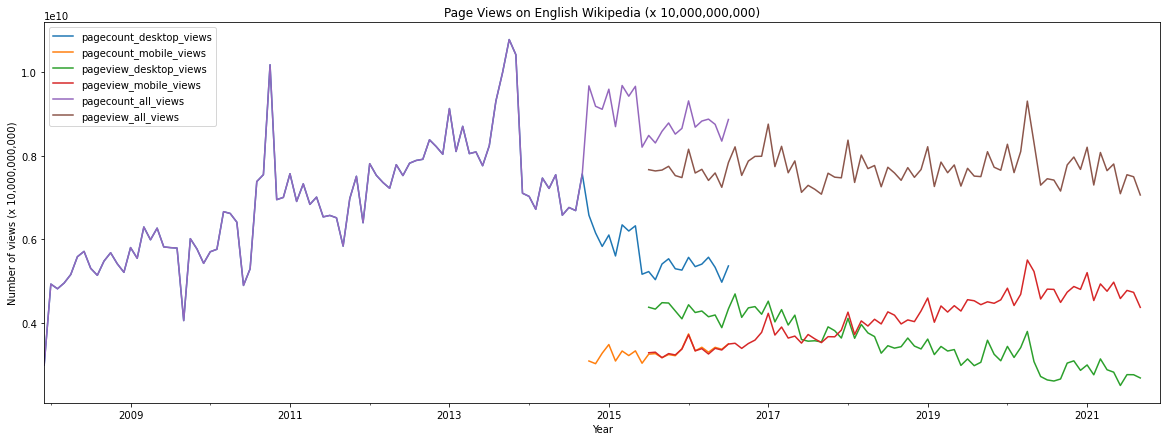

In [263]:
# Delete the last values in for pagecount
result_df.replace(0, np.nan, inplace=True)
result_df.replace(103, np.nan, inplace=True)

ax = result_df.set_index(pd.to_datetime(result_df[['year','month']].assign(day=1))).plot(figsize=(20,7))
ax.set_title("Page Views on English Wikipedia (x 10,000,000,000)")
ax.set_xlabel("Year")
ax.set_ylabel("Number of views (x 10,000,000,000)")
plt.show()

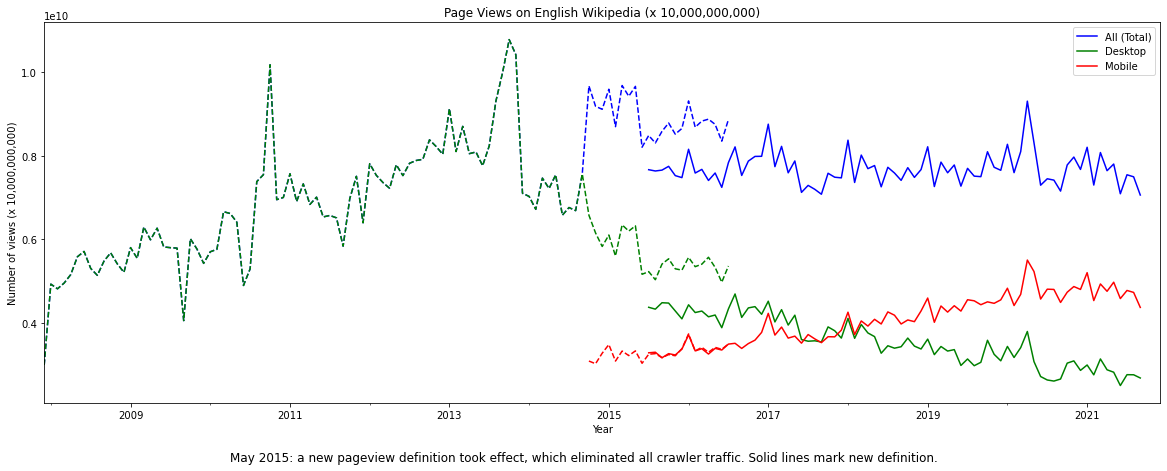

In [264]:
df = result_df.copy()
# Plot the legacy lines first
ax = df[['year', 'month', 'pagecount_all_views', 'pagecount_desktop_views', 'pagecount_mobile_views']].set_index(pd.to_datetime(df[['year','month']].assign(day=1))).plot(figsize=(20,7), style='--', color=['b','g','r'])
# Add the new pageview definition lines to the legacy plot
df[['year', 'month', 'pageview_all_views', 'pageview_desktop_views', 'pageview_mobile_views']].set_index(pd.to_datetime(df[['year','month']].assign(day=1))).plot(figsize=(20,7), style='-', ax=ax, color=['b','g','r'])
# Add a title for the plot
ax.set_title("Page Views on English Wikipedia (x 10,000,000,000)")
# Set the xlabel as year
ax.set_xlabel("Year")
# Set the ylabel as number of views
ax.set_ylabel("Number of views (x 10,000,000,000)")
# Add in legend
custom_lines = [Line2D([0], [0], color='b'),
                Line2D([0], [0], color='g'),
                Line2D([0], [0], color='r')]
ax.legend(custom_lines, ['All (Total)', 'Desktop', 'Mobile'])
# Add footnote regarding legacy and new definition
plt.figtext(0.5, 0.01, "May 2015: a new pageview definition took effect, which eliminated all crawler traffic. Solid lines mark new definition.", wrap=True, horizontalalignment='center', fontsize=12)

plt.savefig("Page Views on English Wikipedia")
# Display the plot
plt.show()